<h1><center>Battle of the Neighborhoods</center></h1>
<h2><center>Best Place to Start a Restaurent in Mumbai</center><h2>

<h3><center> Introduction</center></h3>
<p>This project deals with the exploring the neighborhoods of Mumbai. This project is designed for those who are looking to start a restaurant business in Mumbai. Mumbai is a financial capital of India and houses all types of cultures. One can find a restaurant of any cuisine in Mumbai. This project is for those who are looking to open a new hotel or restaurant. 

The Foursquare API is used to get the details of venues in Mumbai. These venues are then clustered based on data received from the API and then analyzed using the K-Mean Clustering and Silhouette Score. 

The target audience of this project are the small-scale hotel owners and restaurant owners who are planning to open branches in Mumbai and its neighborhoods. The project aims to answer the following questions: <p>
<ol>
    <li>What is the best location to open a new Hotel in Mumbai? </li>
    <li>Which place is most suitable for starting a Mall in Mumbai?</li>
</ol>

<p>Install Folium library for plotting maps of geographical locations</p>

In [1]:
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 6.3 MB/s  eta 0:00:01


<p>Import Libraries required for the project</p>
<ul>
    <li>Regex</li>
    <li>Json</li>
    <li>Numpy</li>
    <li>pandas</li>
    <li>Beautiful Soup</li>
    <li>Requests</li>
    <li>Scikit Learn</li>
    <li>GeoPy</li>
    <li>Folium</li>
    <li>Matplotlib</li>
</ul>

In [2]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


<p>URL of the page to be read</p>
<p>Wikipedia page for List of neighborhoods in Mumbai. Click the link get redirected to the page</p><a href="https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai">List of Neighborhoods in Mumbai</a>

In [3]:
URL = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai"

<p>Send a get request to get the entire HTML page.</p>

In [4]:
data = requests.get(URL).text

<p>Using Beautiful Soup to Extract Data from the page</p>
<p>Create a Beautiful Soup Object</p>

In [5]:
soup = BeautifulSoup(data, "xml")

<p>Create Lists from the Extracted Data</p>
<p>Four List are created</p>
<ul>
    <li>Area</li>
    <li>Location</li>
    <li>Latitude</li>
    <li>Longitude</li>
    
</ul>

In [6]:
Area = []
Location = []
Latitude = []
Longitude = []

td = soup.find_all("td")
for i in range(0, len(td),4):
    Area.append((td[i].text)[0:len((td[i].text))-2])
    Location.append((td[i+1].text)[0:len((td[i+1].text))-2])
    Latitude.append((td[i+2].text)[0:len((td[i+2].text))-2])
    Longitude.append((td[i+3].text)[0:len((td[i+3].text))-2])
# print(len(Area))
# print(len(Location))
# print(len(Latitude))
# print(len(Longitude))


<p>Create a pandas dataframe with the Area, Location, Latitude, Longitude columns</p>

In [7]:
df = pd.DataFrame({
    "Area" : Area,
    "Location" : Location,
    "Latitude" : Latitude,
    "Longitude" : Longitude,
})

<p>Show the first 5 elements of the dataframe to see whether the dataframe was created or not</p>

In [8]:
df.head()

,Area,Location,Latitude,Longitude
0,Ambol,"Andheri,Western Suburb",19.129,72.843
1,"Chakala, Andher",Western Suburb,19.11138,72.86083
2,D.N. Naga,"Andheri,Western Suburb",19.12408,72.83137
3,Four Bungalow,"Andheri,Western Suburb",19.12471,72.8272
4,Lokhandwal,"Andheri,Western Suburb",19.13081,72.8292


In [9]:
df.shape

(93, 4)

<p>Get the geographical coordinated of Mumbai Maharashtra</p>
<p>Using the Nominatim class in the geopy library</p>

In [10]:
address = 'Mumbai, Maharashtra'

geolocator = Nominatim(user_agent="mumbai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Mumbai are 19.0759899, 72.8773928.


<p>Plot a map of Mumbai using the folium library and the coordinates recieved from above</p>

In [11]:
mumbai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
mumbai_map

In [12]:
# add neighborhood markers to map
for lat, lng, location in zip(df['Latitude'], df['Longitude'], df['Area']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mumbai_map)  

mumbai_map

Get you CLIENT_ID, CLIENT_SECRET and VERSION from the FourSquare API Website and add them to variables below

In [13]:
# secret
CLIENT_ID = '3ZOIN1HQSS02FL3JXJ0V5RNMEC1ON5VEEK0OSBITXNRLGCLX' # your Foursquare ID
CLIENT_SECRET = '14EDTT1YA4AZ5W1QUGIT3Q4WFF2JPE2UCPWYQBTGGTFKYWKK' # your Foursquare Secret
VERSION = '20210613' # Foursquare API version

<p>Create a function to get the nearby venues from the latitude and longitude values in the dataframe.</p>
<p>This function sends request to the foursquare api to get the venues</p>

In [14]:
def getNearbyVenues(names, longitudes, latitudes, radius=500, limit=100):
    
    venues_list = []  # create a empty list to hold venues
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # API call request
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={limit}'
        
        # GET Request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]["groups"][0]["items"]
                count = 5
            except:
                count += 1
                
        # Get relevent data
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue',
                            'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return nearby_venues

<p>Make call to the above function and pass the area latitude and longitude values form the original dataframe</p>
<p>Show the shape and first 5 rows of the new dataframe</p>
<p>Columns of this dataframe are</p>
<ul>
    <li>Neighborood</li>
    <li>Neighborood Latitude</li>
    <li>Neighborood Longitude</li>
    <li>Venue</li>
    <li>Venue Latitude</li>
    <li>Venue Longitude</li>
    <li>Venue Category</li>
</ul>

In [15]:
mumbai_venues = getNearbyVenues(df['Area'], df['Longitude'], df['Latitude'])
print(mumbai_venues.shape)
mumbai_venues.head()

(812, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ambol,19.129,72.843,Cafe Arfa,19.128930,72.847140,Indian Restaurant
1,Ambol,19.129,72.843,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
2,Ambol,19.129,72.843,Subway,19.127860,72.844461,Sandwich Place
3,Ambol,19.129,72.843,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
4,Ambol,19.129,72.843,Gelato Italiano,19.128120,72.844154,Ice Cream Shop


<h4>Methodology</h4>
<p>We have the data that has latitudes and longitudes of the neighborhoods in Mumbai and the venues that are nearby. We will only consider neighborhoods for which we have considerable number of venues available. We will have a look at the neighborhood that has the highest number of venues. We have 93 neighborhoods in Mumbai. From the foursquare Api we have received 858 venues. We will take a look at the venue categories and then look at how many unique types of venues were received. 
We use the KMean Clustering, One Head Encoding. These cluster are used to find the best place to open a restaurant. </p>

<h4>Analysis<h4>

<p>Group the data by neighborhoods and show the neighborhood with maximum number of venues</p>

In [16]:
v_ = mumbai_venues.groupby('Neighborhood').count()
v_[v_['Venue'] == max(v_['Venue'])] # Maximum venues

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Hiranandani Garden,55,55,55,55,55,55


<p>Get the number of unique venues that are available</p>

In [17]:
print(f'There are {len(mumbai_venues["Venue Category"].unique())} unique categories.')

There are 149 unique categories.


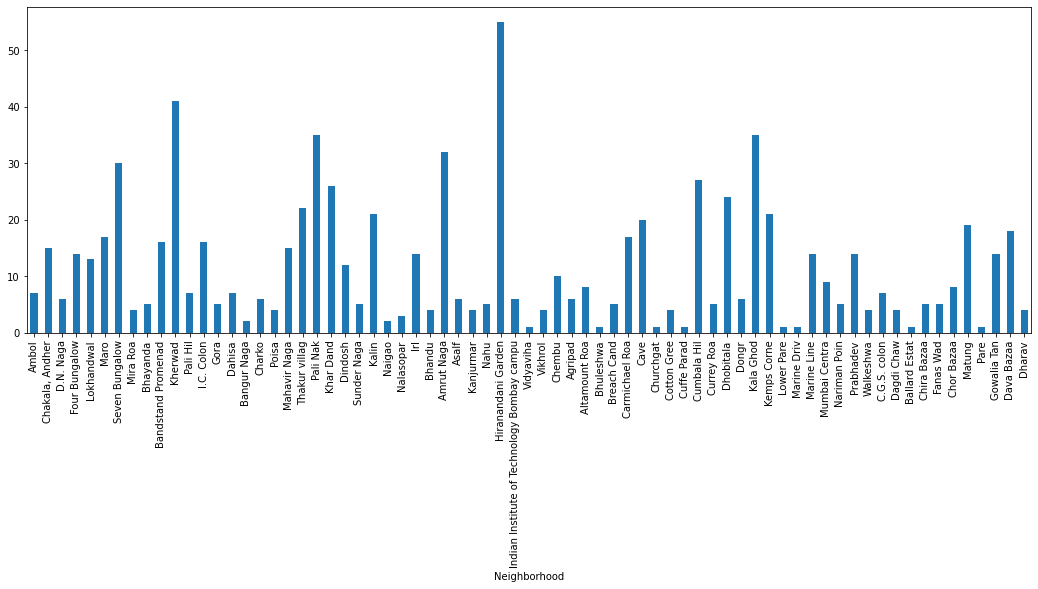

In [18]:
df1 = mumbai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df1.plot.bar(figsize=(18,6))

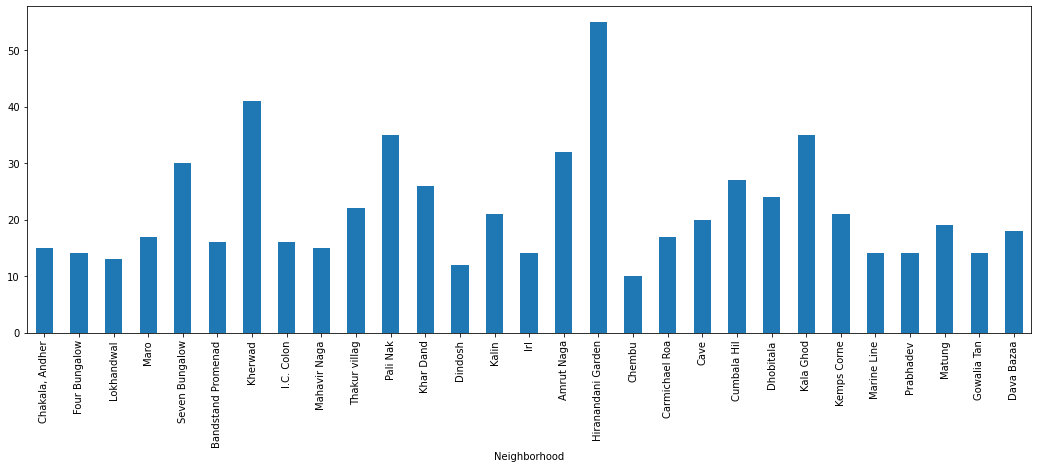

In [19]:
df1=df1[df1 >= 10]
df1.plot.bar(figsize=(18,6))

In [20]:
mumbai_venues_top = mumbai_venues[mumbai_venues['Neighborhood'].isin(df1.index.tolist())]
mumbai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7,"Chakala, Andher",19.11138,72.86083,Cafe Coffee Day,19.112272,72.861106,Café
8,"Chakala, Andher",19.11138,72.86083,Shree,19.112256,72.861113,Restaurant
9,"Chakala, Andher",19.11138,72.86083,Courtyard Mumbai International Airport,19.114167,72.864131,Hotel
10,"Chakala, Andher",19.11138,72.86083,Sai Palace Hotel,19.115373,72.860571,Hotel
11,"Chakala, Andher",19.11138,72.86083,NH1 Kitchen and Bar,19.111335,72.858639,Cocktail Bar


In [21]:
mumbai_onehot = pd.get_dummies(mumbai_venues_top['Venue Category'], prefix = "", prefix_sep="")

#
mumbai_onehot['Neighborhood'] = mumbai_venues_top['Neighborhood']

fixed_columns = mumbai_onehot.columns.tolist()
fixed_columns.insert(0,fixed_columns.pop(fixed_columns.index('Neighborhood')))
mumbai_onehot = mumbai_onehot.reindex(columns = fixed_columns)

print(mumbai_onehot.shape)
mumbai_onehot.head()

(627, 130)


,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Arcade,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Technology Building,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food Truck,French Restaurant,Fried Chicken Joint,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,North Indian Restaurant,Other Great Outdoors,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Tea Room,Tex-Mex Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Women's Store,Yoga Studio
7,"Chakala, Andher",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,"Chakala, Andher",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,"Chakala, Andher",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,"Chakala, Andher",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,"Chakala, Andher",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
mumbai_grouped = mumbai_onehot.groupby('Neighborhood').mean().reset_index()
print(mumbai_grouped.shape)
mumbai_grouped.head()

(29, 130)


,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Arcade,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Technology Building,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food Truck,French Restaurant,Fried Chicken Joint,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,North Indian Restaurant,Other Great Outdoors,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Tea Room,Tex-Mex Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Women's Store,Yoga Studio
0,Amrut Naga,0.0,0.03125,0.03125,0.0,0.0,0.0,0.0,0.031250,0.00,0.0,0.000000,0.00,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0000,0.03125,0.03125,0.0,0.0,0.0,0.0,0.093750,0.00,0.031250,0.09375,0.000000,0.03125,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.000000,0.03125,0.0,0.0,0.0,0.0,0.0,0.03125,0.03125,0.062500,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.0000,0.03125,0.125000,0.0,0.031250,0.0,0.00,0.0,0.0,0.0000,0.00,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.00,0.0,0.0,0.0,0.0,0.031250,0.0,0.0000,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.031250,0.000,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0
1,Bandstand Promenad,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0625,0.00000,0.06250,0.0,0.0,0.0,0.0,0.062500,0.00,0.062500,0.00000,0.062500,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.062500,0.0,0.0,0.00,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.000000,0.0625,0.00000,0.062500,0.0,0.062500,0.0,0.00,0.0,0.0,0.0625,0.00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.125,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0
2,Carmichael Roa,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.058824,0.00,0.0000,0.0,0.0,0.0,0.058824,0.0,0.0000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.058824,0.00,0.058824,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.058824,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.117647,0.0,0.0,0.00,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.058824,0.0,0.0,0.058824,0.0000,0.00000,0.000000,0.0,0.058824,0.0,0.00,0.0,0.0,0.0000,0.00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.058824,0.0,0.0000,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.058824,0.000,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.058824,0.00,0.0,0.0,0.0,0.0
3,Cave,0.0,0.00000,0.00000,0.0,0

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mumbai_grouped['Neighborhood']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amrut Naga,Indian Restaurant,Clothing Store,Café,Fast Food Restaurant,Park,Cosmetics Shop,Coffee Shop,Mediterranean Restaurant,Chinese Restaurant,Pizza Place
1,Bandstand Promenad,Scenic Lookout,Hotel Bar,Boutique,Boat or Ferry,Café,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Beach,Indian Restaurant
2,Carmichael Roa,Fast Food Restaurant,Park,Hotel,Chinese Restaurant,Café,Pizza Place,Deli / Bodega,Bengali Restaurant,Sandwich Place,Shopping Mall
3,Cave,Indian Restaurant,Chinese Restaurant,Café,Bakery,Flea Market,Jewelry Store,Cheese Shop,Bar,Athletics & Sports,Music Store
4,"Chakala, Andher",Pizza Place,Hotel,Restaurant,Café,Cocktail Bar,Multiplex,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Yoga Studio


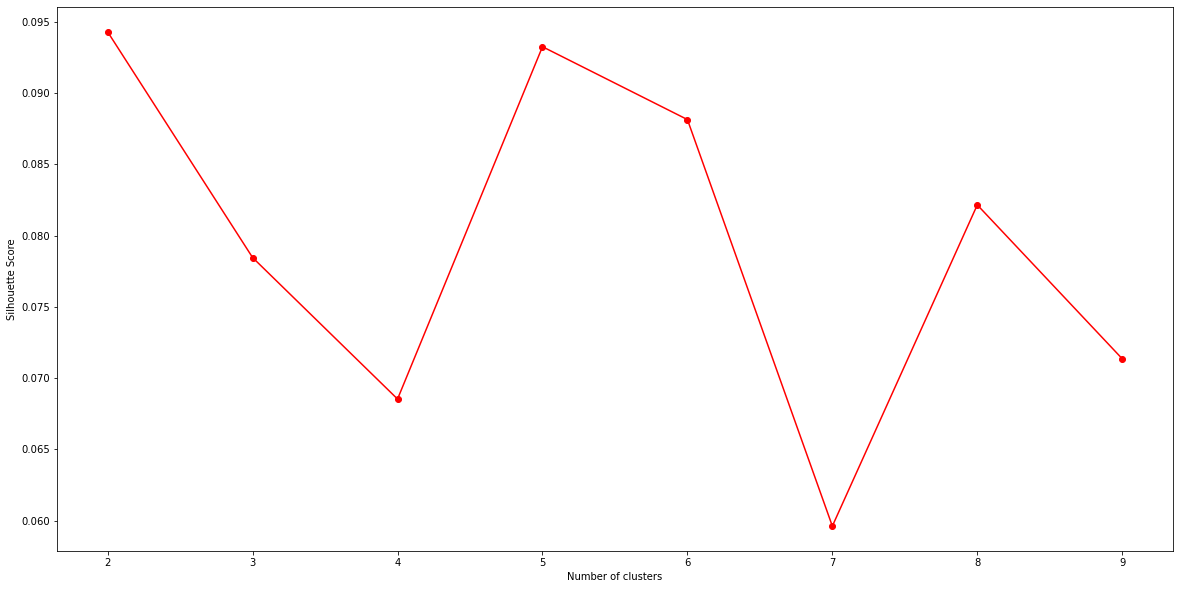

In [25]:
mumbai_grouped_clustering = mumbai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(mumbai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(mumbai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [26]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 8, 3, 6, 2, 5, 7, 3, 1], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mumbai_merged = mumbai_venues_top[mumbai_venues_top.columns[0:3]].drop_duplicates()
mumbai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mumbai_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Chakala, Andher",19.11138,72.86083,6,Pizza Place,Hotel,Restaurant,Café,Cocktail Bar,Multiplex,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Yoga Studio
1,Four Bungalow,19.12471,72.8272,4,Accessories Store,Smoke Shop,Women's Store,Gym,Fish Market,Juice Bar,Market,Pizza Place,Playground,Residential Building (Apartment / Condo)
2,Lokhandwal,19.13081,72.8292,4,Pizza Place,Accessories Store,Residential Building (Apartment / Condo),Women's Store,Gym / Fitness Center,Indian Restaurant,Juice Bar,Liquor Store,Lounge,Market
3,Maro,19.11921,72.88274,1,Bakery,Snack Place,Indian Restaurant,Ice Cream Shop,Asian Restaurant,Restaurant,Department Store,Chinese Restaurant,Coffee Shop,Food
4,Seven Bungalow,19.12905,72.81701,1,Chinese Restaurant,Café,Pub,Ice Cream Shop,Park,Seafood Restaurant,Bar,Coffee Shop,Music Venue,North Indian Restaurant


In [28]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,I.C. Colon,Chinese Restaurant,Dessert Shop,Gift Shop,Bar,Department Store,Liquor Store,Sandwich Place,Juice Bar,Fast Food Restaurant,Paper / Office Supplies Store


In [29]:
cluster1 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Paper / Office Supplies Store    1
Juice Bar                        1
Liquor Store                     1
Chinese Restaurant               1
Fast Food Restaurant             1
Dessert Shop                     1
Department Store                 1
Sandwich Place                   1
Bar                              1
Gift Shop                        1
dtype: int64


In [30]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Maro,Bakery,Snack Place,Indian Restaurant,Ice Cream Shop,Asian Restaurant,Restaurant,Department Store,Chinese Restaurant,Coffee Shop,Food
4,Seven Bungalow,Chinese Restaurant,Café,Pub,Ice Cream Shop,Park,Seafood Restaurant,Bar,Coffee Shop,Music Venue,North Indian Restaurant
5,Bandstand Promenad,Scenic Lookout,Hotel Bar,Boutique,Boat or Ferry,Café,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Beach,Indian Restaurant
6,Kherwad,Bakery,Café,Indian Restaurant,Chinese Restaurant,Gourmet Shop,Snack Place,Bar,Fast Food Restaurant,Clothing Store,Pizza Place
8,Mahavir Naga,Café,Indian Restaurant,Park,Ice Cream Shop,Coffee Shop,Pizza Place,Dessert Shop,Men's Store,Donut Shop,Italian Restaurant
9,Thakur villag,Pizza Place,Breakfast Spot,Park,Electronics Store,North Indian Restaurant,Chinese Restaurant,Pharmacy,Residential Building (Apartment / Condo),Department Store,Dessert Shop
10,Pali Nak,Indian Restaurant,Bakery,Bar,Deli / Bodega,Salad Place,Café,Coffee Shop,Asian Restaurant,Seafood Restaurant,Liquor Store
12,Dindosh,Fast Food Restaurant,Bakery,Ice Cream Shop,Smoke Shop,Indian Restaurant,Bar,Restaurant,Gym / Fitness Center,Gym,Convenience Store
15,Amrut Naga,Indian Restaurant,Clothing Store,Café,Fast Food Restaurant,Park,Cosmetics Shop,Coffee Shop,Mediterranean Restaurant,Chinese Restaurant,Pizza Place
16,Hiranandani Garden,Indian Restaurant,Coffee Shop,Department Store,Restaurant,Bakery,Pizza Place,Donut Shop,Café,Bar,Asian Restaurant


In [31]:
cluster2 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Indian Restaurant       10
Café                     9
Coffee Shop              8
Chinese Restaurant       6
Pizza Place              6
Bar                      6
Bakery                   5
Fast Food Restaurant     5
Park                     5
Ice Cream Shop           4
dtype: int64


In [32]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Chembu,Electronics Store,Coffee Shop,Pool,Smoke Shop,Bar,Diner,Indian Restaurant,Gastropub,General Entertainment,Creperie


In [33]:
cluster3 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Gastropub                1
Smoke Shop               1
Coffee Shop              1
Indian Restaurant        1
Electronics Store        1
Pool                     1
Diner                    1
Creperie                 1
Bar                      1
General Entertainment    1
dtype: int64


In [34]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 3, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Cave,Indian Restaurant,Chinese Restaurant,Café,Bakery,Flea Market,Jewelry Store,Cheese Shop,Bar,Athletics & Sports,Music Store
21,Dhobitala,Indian Restaurant,Bakery,Chinese Restaurant,Café,Coffee Shop,Multiplex,Cricket Ground,Pizza Place,Mexican Restaurant,Jewelry Store
24,Marine Line,Indian Restaurant,Café,Bakery,Chinese Restaurant,Mexican Restaurant,Indie Movie Theater,Flea Market,Coffee Shop,Train Station,Waterfront
25,Prabhadev,Indian Restaurant,Café,Dessert Shop,Multiplex,Theater,Chinese Restaurant,Pizza Place,Food,Falafel Restaurant,Smoke Shop


In [35]:
cluster4 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 3, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Café                  4
Indian Restaurant     4
Chinese Restaurant    4
Bakery                3
Multiplex             2
Jewelry Store         2
Pizza Place           2
Coffee Shop           2
Flea Market           2
Mexican Restaurant    2
dtype: int64


In [36]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 4, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Four Bungalow,Accessories Store,Smoke Shop,Women's Store,Gym,Fish Market,Juice Bar,Market,Pizza Place,Playground,Residential Building (Apartment / Condo)
2,Lokhandwal,Pizza Place,Accessories Store,Residential Building (Apartment / Condo),Women's Store,Gym / Fitness Center,Indian Restaurant,Juice Bar,Liquor Store,Lounge,Market


In [37]:
cluster5 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 4, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Juice Bar                                   2
Accessories Store                           2
Pizza Place                                 2
Women's Store                               2
Market                                      2
Residential Building (Apartment / Condo)    2
Playground                                  1
Liquor Store                                1
Indian Restaurant                           1
Gym / Fitness Center                        1
dtype: int64


In [38]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 5, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Irl,Ice Cream Shop,Café,Fast Food Restaurant,Sandwich Place,Juice Bar,Electronics Store,Snack Place,Indian Restaurant,Seafood Restaurant,Gym
20,Cumbala Hil,Café,Coffee Shop,Fast Food Restaurant,Bakery,Yoga Studio,Smoke Shop,Other Great Outdoors,Department Store,Brewery,Dessert Shop
23,Kemps Corne,Fast Food Restaurant,Dessert Shop,Coffee Shop,Café,Bakery,Bar,Diner,Salon / Barbershop,Sandwich Place,Concert Hall
27,Gowalia Tan,Restaurant,Gastropub,Bookstore,Park,History Museum,Brewery,Hotel,Coffee Shop,Concert Hall,Clothing Store


In [39]:
cluster6 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 5, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Café                    3
Coffee Shop             3
Fast Food Restaurant    3
Concert Hall            2
Sandwich Place          2
Brewery                 2
Dessert Shop            2
Bakery                  2
Park                    1
Gastropub               1
dtype: int64


In [40]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 6, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Chakala, Andher",Pizza Place,Hotel,Restaurant,Café,Cocktail Bar,Multiplex,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Yoga Studio


In [41]:
cluster7 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 6, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Café                    1
Restaurant              1
Pizza Place             1
Multiplex               1
Asian Restaurant        1
Hotel                   1
Fast Food Restaurant    1
Yoga Studio             1
Cocktail Bar            1
Indian Restaurant       1
dtype: int64


In [42]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 7, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Khar Dand,Indian Restaurant,Bar,Pub,Lounge,Hotel,Market,Plaza,Bengali Restaurant,Fast Food Restaurant,Beer Bar
13,Kalin,Indian Restaurant,Market,Jewelry Store,Chinese Restaurant,Sandwich Place,Bus Station,Pizza Place,Hotel,Fast Food Restaurant,Middle Eastern Restaurant
28,Dava Bazaa,Indian Restaurant,Jewelry Store,Breakfast Spot,Electronics Store,Café,Fast Food Restaurant,Ice Cream Shop,Bar,Cheese Shop,Market


In [43]:
cluster8 = mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 7, mumbai_merged.columns[[0] + 
                                                                                    list(range(4, mumbai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Indian Restaurant       3
Market                  3
Fast Food Restaurant    3
Jewelry Store           2
Hotel                   2
Bar                     2
Café                    1
Plaza                   1
Ice Cream Shop          1
Beer Bar                1
dtype: int64


<h4>Discussion</h4>

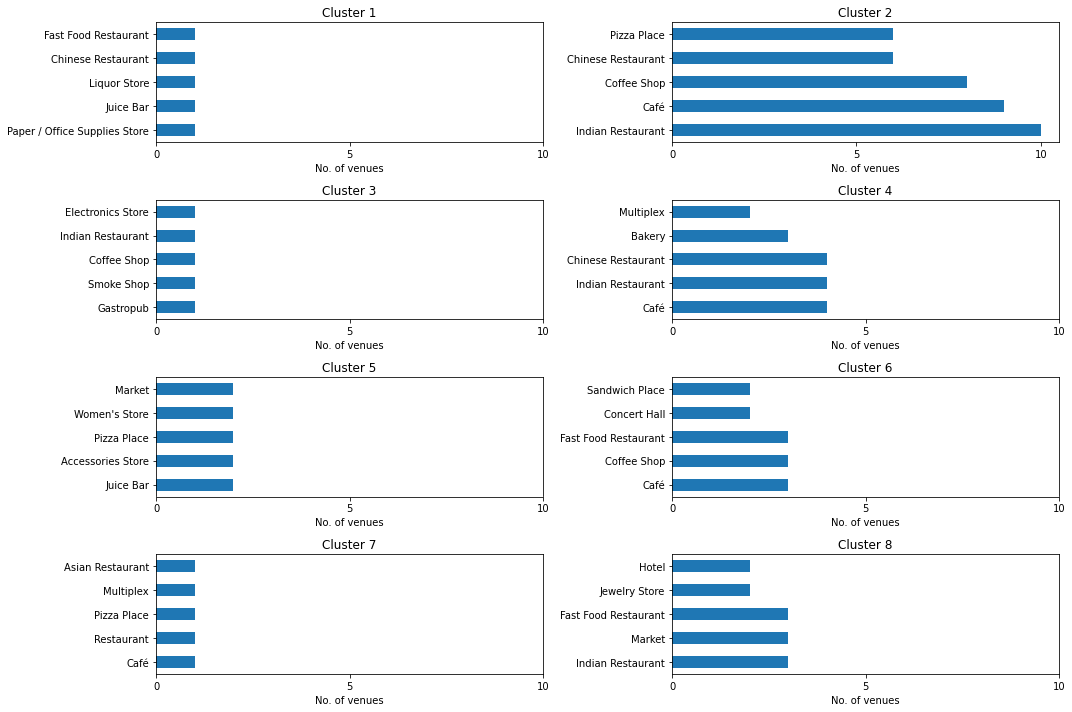

In [44]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

In [45]:
# create map
mumbai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Neighborhood Latitude'], mumbai_merged['Neighborhood Longitude'], mumbai_merged['Neighborhood'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mumbai_clusters_map)
       
mumbai_clusters_map